# Self-supervised PDB similarity gap filling (U-Net)

This notebook trains a 2D U-Net to reconstruct missing rows and columns in 100x100 similarity matrices derived from PDB structures.

- Inputs: masked similarity + missing mask + valid mask (no padding)
- Loss: only on missing positions within the valid region; symmetry and diagonal=1 are enforced
- Baselines: nearest, linear (separable/bilinear), min
- Metrics: MSE / MAE on masked positions only


## Data
Uses precomputed similarity matrices from `data/precomputed_L100` (or the newest `precomputed_L*` directory) created by `pdb_pipeline.ipynb`.


In [1]:
from __future__ import annotations

from pathlib import Path
import csv
import random
import math
import time

import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt

DATA_ROOT = Path("data")
PRECOMPUTED_DIR = None  # set Path("data/precomputed_L100") if needed
RANDOM_SEED = 42
TRAIN_FRACTION = 0.8
VAL_FRACTION = 0.1
BATCH_SIZE = 32
NUM_WORKERS = 0
MASK_FRACTIONS = [0.05, 0.10, 0.20, 0.30]
EPOCHS = 10
LR = 1e-3
WEIGHT_DECAY = 0.0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_TRAIN_SAMPLES = None  # set an int for quick runs
MAX_EVAL_SAMPLES = None

print("Device:", DEVICE)


Device: cuda


In [2]:
def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def _extract_len(path: Path) -> int:
    prefix = "precomputed_L"
    if not path.name.startswith(prefix):
        return -1
    try:
        return int(path.name[len(prefix) :])
    except ValueError:
        return -1


def _find_precomputed(root: Path) -> Path:
    candidates = sorted(root.glob("precomputed_L*"), key=_extract_len)
    if not candidates:
        raise FileNotFoundError("No precomputed_L* directory found in data/.")
    return candidates[-1]


set_seed(RANDOM_SEED)

# do wyjebania precomputed jakies sraka
if PRECOMPUTED_DIR is None:
    PRECOMPUTED_DIR = _find_precomputed(DATA_ROOT)

MANIFEST_PATH = PRECOMPUTED_DIR / "manifest.csv"
if not MANIFEST_PATH.exists():
    raise FileNotFoundError(f"Missing manifest: {MANIFEST_PATH}")

print(f"Using precomputed dir: {PRECOMPUTED_DIR}")
print(f"Manifest: {MANIFEST_PATH}")


Using precomputed dir: data\precomputed_L100
Manifest: data\precomputed_L100\manifest.csv


In [3]:
with MANIFEST_PATH.open("r", newline="") as handle:
    reader = csv.DictReader(handle)
    manifest_records = list(reader)

ok_records = [r for r in manifest_records if r["status"] == "ok"]
print(f"Total records: {len(manifest_records)}")
print(f"OK records: {len(ok_records)}")


Total records: 6631
OK records: 6631


In [4]:
class SimilarityDataset(Dataset):
    def __init__(self, records):
        self.records = list(records)
        if not self.records:
            raise ValueError("No records provided to the dataset.")

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx: int):
        rec = self.records[idx]
        sim = torch.load(rec["sim_path"]).float()
        n_used = int(rec["n_used"]) if rec["n_used"] else sim.shape[-1]
        return sim, n_used, idx


dataset = SimilarityDataset(ok_records)
indices = list(range(len(dataset)))
random.Random(RANDOM_SEED).shuffle(indices)

n_total = len(indices)
n_train = int(TRAIN_FRACTION * n_total)
n_val = int(VAL_FRACTION * n_total)
train_idx = indices[:n_train]
val_idx = indices[n_train : n_train + n_val]
test_idx = indices[n_train + n_val :]

if MAX_TRAIN_SAMPLES:
    train_idx = train_idx[:MAX_TRAIN_SAMPLES]
if MAX_EVAL_SAMPLES:
    val_idx = val_idx[:MAX_EVAL_SAMPLES]
    test_idx = test_idx[:MAX_EVAL_SAMPLES]

train_ds = Subset(dataset, train_idx)
val_ds = Subset(dataset, val_idx)
test_ds = Subset(dataset, test_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Train samples: {len(train_ds)}")
print(f"Val samples: {len(val_ds)}")
print(f"Test samples: {len(test_ds)}")


Train samples: 5304
Val samples: 663
Test samples: 664


In [5]:
def make_valid_mask(n_used: int, size: int) -> torch.Tensor:
    mask = torch.zeros((size, size), dtype=torch.bool)
    mask[:n_used, :n_used] = True
    return mask


def row_col_mask(n_used: int, size: int, mask_fraction: float, generator: torch.Generator | None) -> torch.Tensor:
    missing = torch.zeros((size, size), dtype=torch.bool)
    if n_used <= 1:
        return missing
    k = int(round(mask_fraction * n_used))
    k = max(1, k)
    k = min(k, n_used - 1)
    if k <= 0:
        return missing
    perm = torch.randperm(n_used, generator=generator)
    idx = perm[:k]
    missing[idx, :n_used] = True
    missing[:n_used, idx] = True
    return missing


def apply_mask_batch(
    sim_batch: torch.Tensor,
    n_used_batch: torch.Tensor,
    mask_fraction: float,
    generator: torch.Generator | None = None,
    sample_ids: torch.Tensor | None = None,
    deterministic: bool = False,
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    b, h, w = sim_batch.shape
    masked_sim = sim_batch.clone()
    missing_mask = torch.zeros_like(sim_batch, dtype=torch.bool)
    valid_mask = torch.zeros_like(sim_batch, dtype=torch.bool)

    for i in range(b):
        n_used = int(n_used_batch[i])
        valid_mask[i, :n_used, :n_used] = True
        if deterministic and sample_ids is not None:
            seed = RANDOM_SEED + int(mask_fraction * 1000) * 100000 + int(sample_ids[i])
            gen = torch.Generator()
            gen.manual_seed(seed)
        else:
            gen = generator
        miss = row_col_mask(n_used, h, mask_fraction, gen)
        missing_mask[i] = miss

    diag_mask = torch.eye(h, dtype=torch.bool).unsqueeze(0).expand(b, h, w)
    missing_mask = missing_mask & valid_mask & ~diag_mask

    masked_sim = masked_sim * valid_mask.float()
    masked_sim[missing_mask] = 0.0
    masked_sim[diag_mask & valid_mask] = 1.0

    target = sim_batch * valid_mask.float()
    target[diag_mask & valid_mask] = 1.0

    return masked_sim, missing_mask, valid_mask, target


In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class UNet2D(nn.Module):
    def __init__(self, in_ch: int = 3, out_ch: int = 1, features: tuple[int, int, int] = (32, 64, 128)):
        super().__init__()
        f1, f2, f3 = features
        self.down1 = DoubleConv(in_ch, f1)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(f1, f2)
        self.pool2 = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(f2, f3)

        self.up2 = nn.ConvTranspose2d(f3, f2, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(f2 + f2, f2)
        self.up1 = nn.ConvTranspose2d(f2, f1, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(f1 + f1, f1)
        self.out = nn.Conv2d(f1, out_ch, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.down1(x)
        x2 = self.down2(self.pool1(x1))
        x3 = self.bottleneck(self.pool2(x2))

        x = self.up2(x3)
        x = torch.cat([x, x2], dim=1)
        x = self.dec2(x)

        x = self.up1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec1(x)

        return self.out(x)


In [7]:
def postprocess_pred(pred: torch.Tensor, valid_mask: torch.Tensor) -> torch.Tensor:
    if pred.dim() == 4:
        pred = pred.squeeze(1)
    pred = torch.sigmoid(pred)
    pred = 0.5 * (pred + pred.transpose(-1, -2))
    pred = pred * valid_mask.float()
    diag_mask = torch.eye(pred.size(-1), device=pred.device, dtype=torch.bool).unsqueeze(0)
    pred[diag_mask & valid_mask] = 1.0
    return pred


def masked_mse(pred: torch.Tensor, target: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    mask_f = mask.float()
    denom = mask_f.sum().clamp(min=1.0)
    diff = (pred - target) * mask_f
    return (diff * diff).sum() / denom


def masked_mae(pred: torch.Tensor, target: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    mask_f = mask.float()
    denom = mask_f.sum().clamp(min=1.0)
    diff = (pred - target).abs() * mask_f
    return diff.sum() / denom


In [8]:
def train_one_epoch(model, loader, optimizer, mask_fraction, device, generator):
    model.train()
    total_mse = 0.0
    total_mae = 0.0
    total_count = 0

    for sim_batch, n_used_batch, _ in loader:
        masked_sim, missing_mask, valid_mask, target = apply_mask_batch(
            sim_batch, n_used_batch, mask_fraction, generator=generator
        )
        inputs = torch.stack(
            [masked_sim, missing_mask.float(), valid_mask.float()], dim=1
        ).to(device)
        target = target.to(device)
        missing_mask = missing_mask.to(device)
        valid_mask = valid_mask.to(device)

        optimizer.zero_grad(set_to_none=True)
        pred_raw = model(inputs)
        pred = postprocess_pred(pred_raw, valid_mask)
        loss = masked_mse(pred, target, missing_mask)
        mae = masked_mae(pred, target, missing_mask)
        loss.backward()
        optimizer.step()

        bs = sim_batch.size(0)
        total_mse += loss.item() * bs
        total_mae += mae.item() * bs
        total_count += bs

    return total_mse / max(1, total_count), total_mae / max(1, total_count)


@torch.no_grad()
def eval_model(model, loader, mask_fraction, device, deterministic: bool = True):
    model.eval()
    total_mse = 0.0
    total_mae = 0.0
    total_count = 0

    for sim_batch, n_used_batch, sample_ids in loader:
        masked_sim, missing_mask, valid_mask, target = apply_mask_batch(
            sim_batch,
            n_used_batch,
            mask_fraction,
            generator=None,
            sample_ids=sample_ids,
            deterministic=deterministic,
        )
        inputs = torch.stack(
            [masked_sim, missing_mask.float(), valid_mask.float()], dim=1
        ).to(device)
        target = target.to(device)
        missing_mask = missing_mask.to(device)
        valid_mask = valid_mask.to(device)

        pred_raw = model(inputs)
        pred = postprocess_pred(pred_raw, valid_mask)
        mse = masked_mse(pred, target, missing_mask)
        mae = masked_mae(pred, target, missing_mask)

        bs = sim_batch.size(0)
        total_mse += mse.item() * bs
        total_mae += mae.item() * bs
        total_count += bs

    return total_mse / max(1, total_count), total_mae / max(1, total_count)


In [9]:
def baseline_nearest(sim: torch.Tensor, n_used: int, missing_mask: torch.Tensor) -> torch.Tensor:
    filled = sim.clone()
    if n_used <= 1:
        return filled
    row_masked = missing_mask[:n_used, :n_used].any(dim=1)
    masked_idx = torch.nonzero(row_masked).flatten().tolist()
    available_idx = [i for i in range(n_used) if i not in masked_idx]
    if not available_idx:
        return filled
    for i in masked_idx:
        nearest = min(available_idx, key=lambda j: abs(j - i))
        filled[i, :n_used] = filled[nearest, :n_used]
        filled[:n_used, i] = filled[:n_used, nearest]
    return filled


def baseline_linear(sim: torch.Tensor, n_used: int, missing_mask: torch.Tensor) -> torch.Tensor:
    filled = sim.clone()
    if n_used <= 1:
        return filled
    row_masked = missing_mask[:n_used, :n_used].any(dim=1)
    masked_idx = torch.nonzero(row_masked).flatten().tolist()
    available_idx = [i for i in range(n_used) if i not in masked_idx]
    if not available_idx:
        return filled

    for i in masked_idx:
        lower = max([j for j in available_idx if j < i], default=None)
        upper = min([j for j in available_idx if j > i], default=None)
        if lower is None and upper is None:
            continue
        if lower is None:
            filled[i, :n_used] = filled[upper, :n_used]
        elif upper is None:
            filled[i, :n_used] = filled[lower, :n_used]
        else:
            t = (i - lower) / float(upper - lower)
            filled[i, :n_used] = (1.0 - t) * filled[lower, :n_used] + t * filled[upper, :n_used]

    for i in masked_idx:
        lower = max([j for j in available_idx if j < i], default=None)
        upper = min([j for j in available_idx if j > i], default=None)
        if lower is None and upper is None:
            continue
        if lower is None:
            filled[:n_used, i] = filled[:n_used, upper]
        elif upper is None:
            filled[:n_used, i] = filled[:n_used, lower]
        else:
            t = (i - lower) / float(upper - lower)
            filled[:n_used, i] = (1.0 - t) * filled[:n_used, lower] + t * filled[:n_used, upper]

    return filled


def baseline_min(sim: torch.Tensor, n_used: int, missing_mask: torch.Tensor, valid_mask: torch.Tensor) -> torch.Tensor:
    filled = sim.clone()
    valid = valid_mask[:n_used, :n_used] & ~missing_mask[:n_used, :n_used]
    if valid.any():
        min_val = sim[:n_used, :n_used][valid].min()
    else:
        min_val = torch.tensor(0.0)
    filled[missing_mask] = min_val
    return filled


def postprocess_baseline(pred: torch.Tensor, valid_mask: torch.Tensor) -> torch.Tensor:
    pred = 0.5 * (pred + pred.transpose(-1, -2))
    pred = pred * valid_mask.float()
    diag_mask = torch.eye(pred.size(-1), dtype=torch.bool)
    pred[diag_mask & valid_mask] = 1.0
    return pred


@torch.no_grad()
def eval_baselines(loader, mask_fraction: float) -> dict:
    totals = {
        "nearest": {"mse": 0.0, "mae": 0.0, "count": 0},
        "linear": {"mse": 0.0, "mae": 0.0, "count": 0},
        "min": {"mse": 0.0, "mae": 0.0, "count": 0},
    }

    for sim_batch, n_used_batch, sample_ids in loader:
        masked_sim, missing_mask, valid_mask, target = apply_mask_batch(
            sim_batch,
            n_used_batch,
            mask_fraction,
            generator=None,
            sample_ids=sample_ids,
            deterministic=True,
        )

        for i in range(sim_batch.size(0)):
            sim_in = masked_sim[i]
            gt = target[i]
            miss = missing_mask[i]
            valid = valid_mask[i]
            n_used = int(n_used_batch[i])

            pred_nearest = baseline_nearest(sim_in, n_used, miss)
            pred_nearest = postprocess_baseline(pred_nearest, valid)
            pred_linear = baseline_linear(sim_in, n_used, miss)
            pred_linear = postprocess_baseline(pred_linear, valid)
            pred_min = baseline_min(sim_in, n_used, miss, valid)
            pred_min = postprocess_baseline(pred_min, valid)

            for name, pred in [("nearest", pred_nearest), ("linear", pred_linear), ("min", pred_min)]:
                mse = masked_mse(pred, gt, miss).item()
                mae = masked_mae(pred, gt, miss).item()
                totals[name]["mse"] += mse
                totals[name]["mae"] += mae
                totals[name]["count"] += 1

    results = {}
    for name, agg in totals.items():
        count = max(1, agg["count"])
        results[name] = {
            "mse": agg["mse"] / count,
            "mae": agg["mae"] / count,
        }
    return results


In [10]:
def train_for_mask_fraction(mask_fraction: float):
    print(f"=== Mask fraction: {mask_fraction:.2f} ===")
    model = UNet2D().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    gen = torch.Generator().manual_seed(RANDOM_SEED + int(mask_fraction * 1000))

    history = []
    for epoch in range(1, EPOCHS + 1):
        t0 = time.time()
        train_mse, train_mae = train_one_epoch(model, train_loader, optimizer, mask_fraction, DEVICE, gen)
        val_mse, val_mae = eval_model(model, val_loader, mask_fraction, DEVICE, deterministic=True)
        history.append((train_mse, train_mae, val_mse, val_mae))
        dt = time.time() - t0
        print(
            f"Epoch {epoch:02d}/{EPOCHS} - "
            f"train MSE {train_mse:.6f} MAE {train_mae:.6f} | "
            f"val MSE {val_mse:.6f} MAE {val_mae:.6f} | {dt:.1f}s"
        )

    test_mse, test_mae = eval_model(model, test_loader, mask_fraction, DEVICE, deterministic=True)
    print(f"Test MSE {test_mse:.6f} MAE {test_mae:.6f}")
    return model, history, (test_mse, test_mae)


In [11]:
results = []
models = {}

for frac in MASK_FRACTIONS:
    model, history, (test_mse, test_mae) = train_for_mask_fraction(frac)
    models[frac] = model
    results.append({
        "mask_fraction": frac,
        "method": "unet",
        "mse": test_mse,
        "mae": test_mae,
    })

    base_metrics = eval_baselines(test_loader, frac)
    for name, metrics in base_metrics.items():
        results.append({
            "mask_fraction": frac,
            "method": name,
            "mse": metrics["mse"],
            "mae": metrics["mae"],
        })

print("Results (lower is better):")
for row in results:
    print(row)


=== Mask fraction: 0.05 ===
Epoch 01/10 - train MSE 0.018594 MAE 0.088403 | val MSE 0.004823 MAE 0.048390 | 4.1s
Epoch 02/10 - train MSE 0.004210 MAE 0.044805 | val MSE 0.003593 MAE 0.040884 | 3.8s
Epoch 03/10 - train MSE 0.003101 MAE 0.038754 | val MSE 0.002849 MAE 0.037602 | 3.8s
Epoch 04/10 - train MSE 0.002691 MAE 0.035804 | val MSE 0.002549 MAE 0.035117 | 3.8s
Epoch 05/10 - train MSE 0.002434 MAE 0.033630 | val MSE 0.002304 MAE 0.032256 | 3.8s
Epoch 06/10 - train MSE 0.002288 MAE 0.032296 | val MSE 0.002114 MAE 0.031367 | 3.8s
Epoch 07/10 - train MSE 0.002139 MAE 0.030977 | val MSE 0.001992 MAE 0.030149 | 3.9s
Epoch 08/10 - train MSE 0.001929 MAE 0.029088 | val MSE 0.001745 MAE 0.027389 | 3.9s
Epoch 09/10 - train MSE 0.001797 MAE 0.027734 | val MSE 0.001729 MAE 0.027075 | 3.8s
Epoch 10/10 - train MSE 0.001710 MAE 0.026759 | val MSE 0.001659 MAE 0.025980 | 3.8s
Test MSE 0.001638 MAE 0.025983
=== Mask fraction: 0.10 ===
Epoch 01/10 - train MSE 0.015481 MAE 0.081413 | val MSE 0.00506

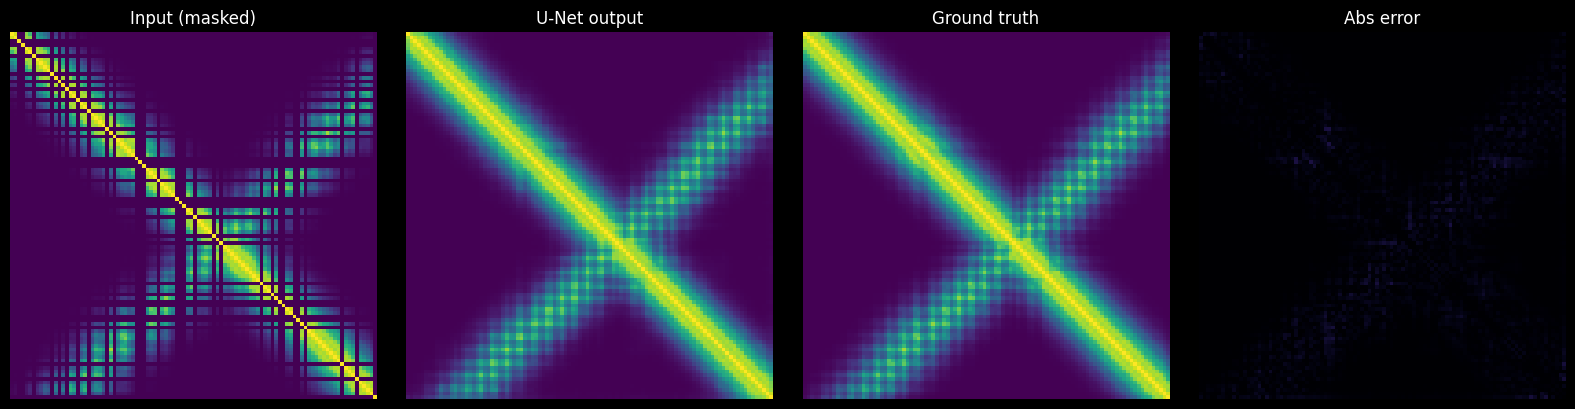

In [12]:
def show_example(mask_fraction: float):
    model = models[mask_fraction]
    model.eval()
    batch = next(iter(test_loader))
    sim_batch, n_used_batch, sample_ids = batch
    masked_sim, missing_mask, valid_mask, target = apply_mask_batch(
        sim_batch,
        n_used_batch,
        mask_fraction,
        generator=None,
        sample_ids=sample_ids,
        deterministic=True,
    )

    inputs = torch.stack(
        [masked_sim, missing_mask.float(), valid_mask.float()], dim=1
    ).to(DEVICE)
    valid_mask = valid_mask.to(DEVICE)
    with torch.no_grad():
        pred = postprocess_pred(model(inputs), valid_mask).cpu()

    i = 0
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    axes[0].imshow(masked_sim[i], vmin=0, vmax=1, cmap="viridis")
    axes[0].set_title("Input (masked)")
    axes[1].imshow(pred[i], vmin=0, vmax=1, cmap="viridis")
    axes[1].set_title("U-Net output")
    axes[2].imshow(target[i], vmin=0, vmax=1, cmap="viridis")
    axes[2].set_title("Ground truth")
    err = (pred[i] - target[i]).abs()
    axes[3].imshow(err, vmin=0, vmax=1, cmap="magma")
    axes[3].set_title("Abs error")
    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


show_example(MASK_FRACTIONS[3])
